In [1]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm

import pynbody
from pynbody.analysis import profile

import os
import glob

from tqdm.notebook import tqdm

import sys
sys.path.append('../../py/')

from cosmoSim import cosmoSim

In [2]:
matplotlib.rc('xtick', labelsize=12)
matplotlib.rc('ytick', labelsize=12)
matplotlib.rcParams['font.size']=12

In [3]:
data_path = "/home/ryan/Data/"
base_path="../../data_prods/"

out_path = '../../plots/movie_710_HY/'


try:
    os.mkdir(out_path)
except:
    print(f'{out_path} already exists!')

../../plots/movie_710_HY/ already exists!


In [4]:
CDM_RUNS = [
    'run_CDM_710_HY'
]

tcDM_search = '../../data_prods/run_2cDM_710_HY_power00*Vkick*'

tcDM_RUNS = [ os.path.basename(x) for x in sorted(glob.glob(tcDM_search)) ]

In [5]:
z_max = 5

with open('../../file_parts/ExpansionList_128', 'r') as f:
    lines = f.read().split('\n')

a = np.array([ float(l.strip().split(' ')[0]) for l in lines if l])

zs = 1/a - 1

zs = zs[ zs < z_max ]

In [6]:
Vkicks = [ cosmoSim(x).Vkick for x in tcDM_RUNS ]

c_norm = matplotlib.colors.LogNorm(vmin=np.amin(Vkicks), vmax=np.amax(Vkicks))
c_map = matplotlib.cm.plasma

s_map = matplotlib.cm.ScalarMappable(cmap=c_map, norm=c_norm)

In [7]:
soft_eff = 100000 / 2**10 / 39

In [8]:
def calculate_profile(run_name, redshift):
    
    run = cosmoSim(run_name, base_path=base_path)
    idx = run.redshift_to_index(redshift)
    # load the file
    # print(data_path + f'/{run_name}/snap_{idx:03}.hdf5')
    f = pynbody.load(data_path + f'/{run_name}/snap_{idx:03}.hdf5')
    h = f.halos(subhalos=True)

    f.physical_units()
    
    # only care about most massive halo for now
    pynbody.analysis.faceon(h[0])
    p_3d = profile.Profile(h[0], rmin = '.05 kpc', rmax = '100 kpc', ndim = 3)
    return p_3d['rbins'].in_units('kpc'), p_3d['density'].in_units('Msol kpc^-3')

  0%|          | 0/83 [00:00<?, ?it/s]

64 run_2cDM_710_HY_power00_sigma1_dir_0_Vkick20.00


/home/ryan/miniconda3/envs/work/lib/python3.12/site-packages/pynbody/snapshot/gadgethdf.py:761: UserWarning: Masses are either stored in the header or have another dataset name; assuming the cosmological factor h**-1
  warnings.warn("Masses are either stored in the header or have another dataset name; assuming the cosmological factor %s" % units.h**-1)


64 run_2cDM_710_HY_power00_sigma1_dir_1_Vkick25.83
64 run_2cDM_710_HY_power00_sigma1_dir_2_Vkick33.36
64 run_2cDM_710_HY_power00_sigma1_dir_3_Vkick43.09
64 run_2cDM_710_HY_power00_sigma1_dir_4_Vkick55.65
64 run_2cDM_710_HY_power00_sigma1_dir_5_Vkick71.88
64 run_2cDM_710_HY_power00_sigma1_dir_6_Vkick92.83
64 run_2cDM_710_HY_power00_sigma1_dir_7_Vkick119.90
64 run_2cDM_710_HY_power00_sigma1_dir_8_Vkick154.85
64 run_2cDM_710_HY_power00_sigma1_dir_9_Vkick200.00
65 run_2cDM_710_HY_power00_sigma1_dir_0_Vkick20.00
65 run_2cDM_710_HY_power00_sigma1_dir_1_Vkick25.83
65 run_2cDM_710_HY_power00_sigma1_dir_2_Vkick33.36
65 run_2cDM_710_HY_power00_sigma1_dir_3_Vkick43.09
65 run_2cDM_710_HY_power00_sigma1_dir_4_Vkick55.65
65 run_2cDM_710_HY_power00_sigma1_dir_5_Vkick71.88
65 run_2cDM_710_HY_power00_sigma1_dir_6_Vkick92.83
65 run_2cDM_710_HY_power00_sigma1_dir_7_Vkick119.90
65 run_2cDM_710_HY_power00_sigma1_dir_8_Vkick154.85
65 run_2cDM_710_HY_power00_sigma1_dir_9_Vkick200.00
66 run_2cDM_710_HY_power0

KeyError: "'mass' is a family-level array for [<Family gas>, <Family dm>, <Family star>]. To use it over the whole simulation you need either to delete it first, or create it separately for []."

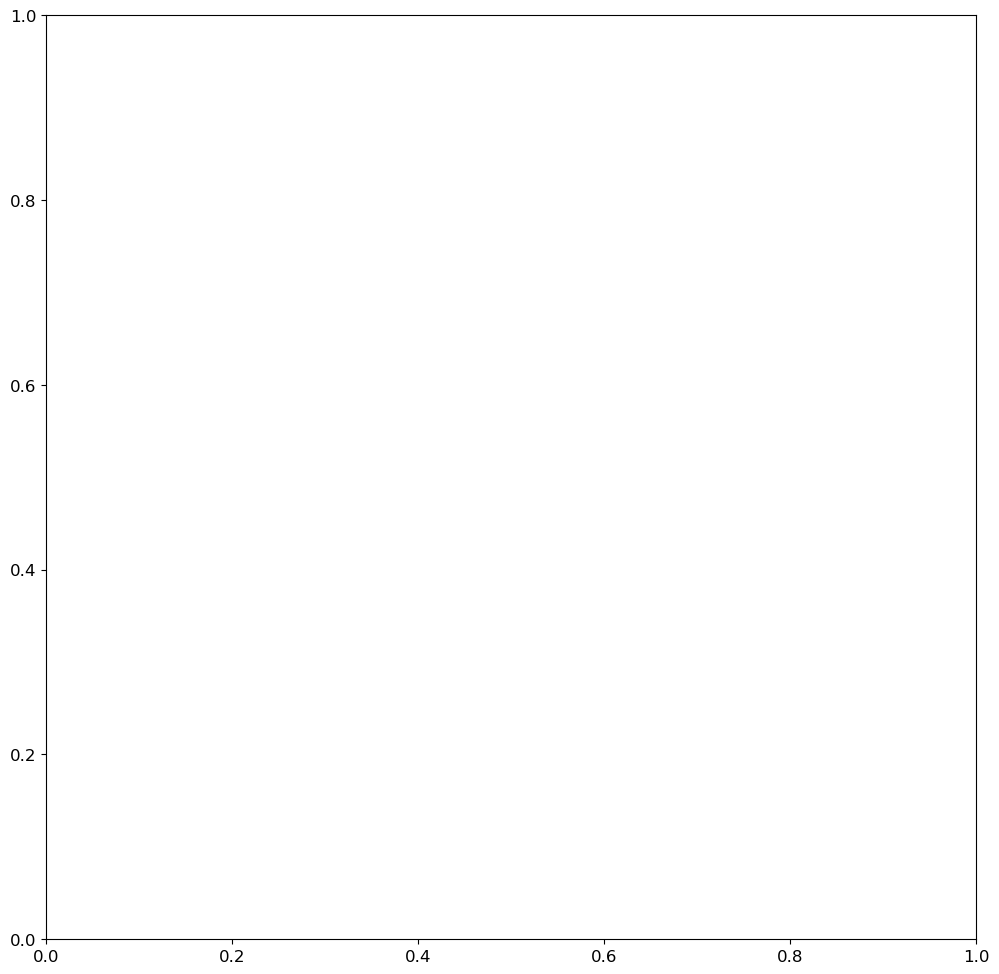

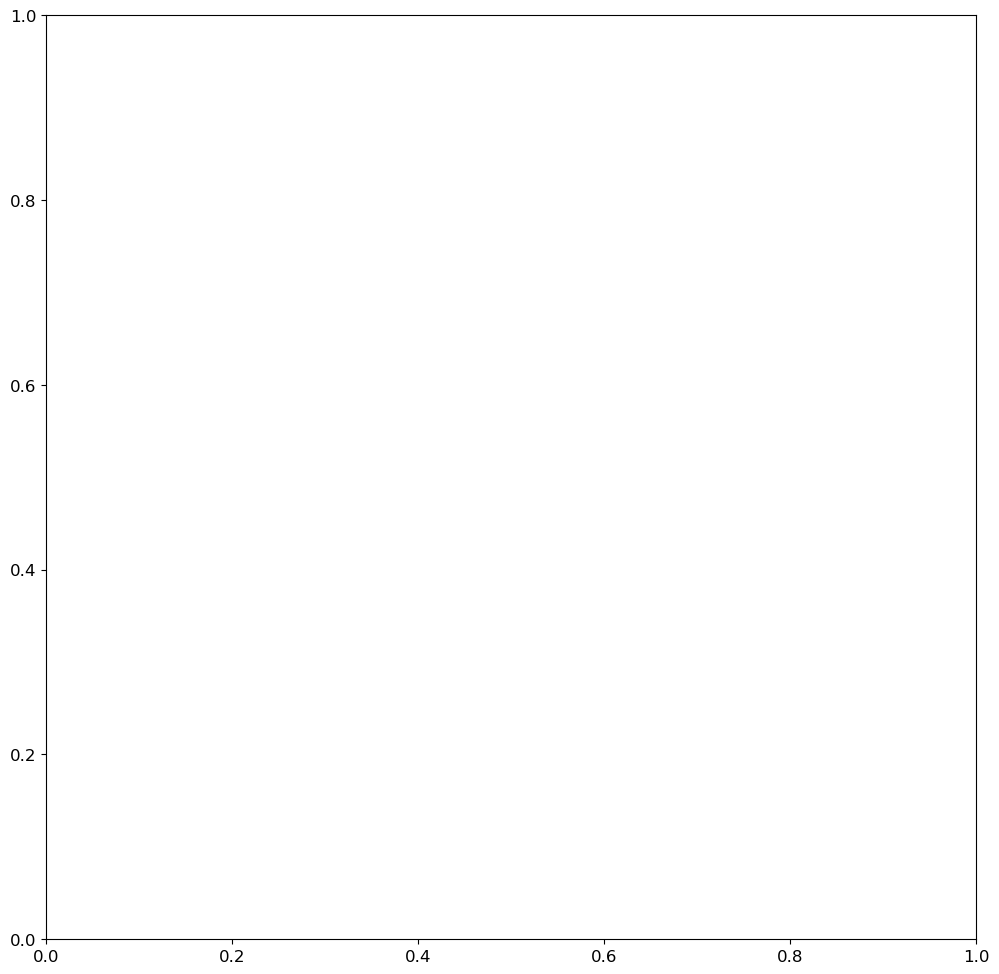

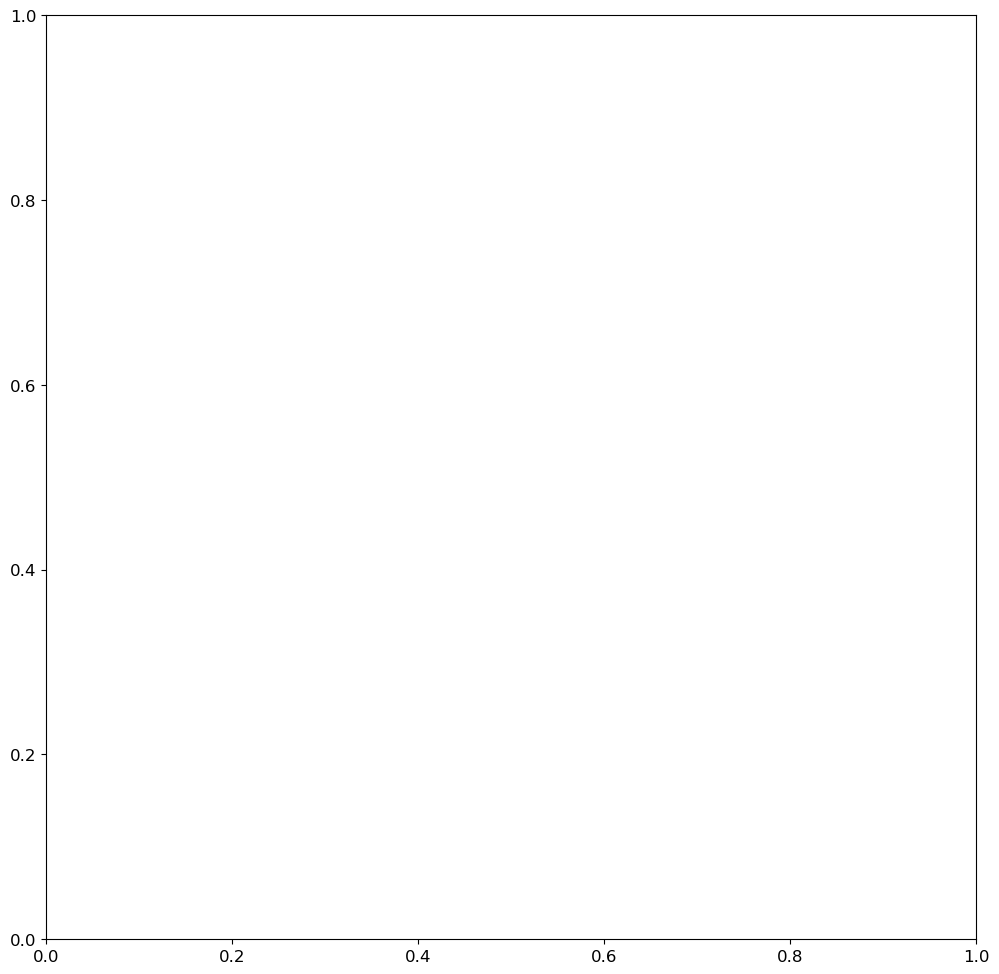

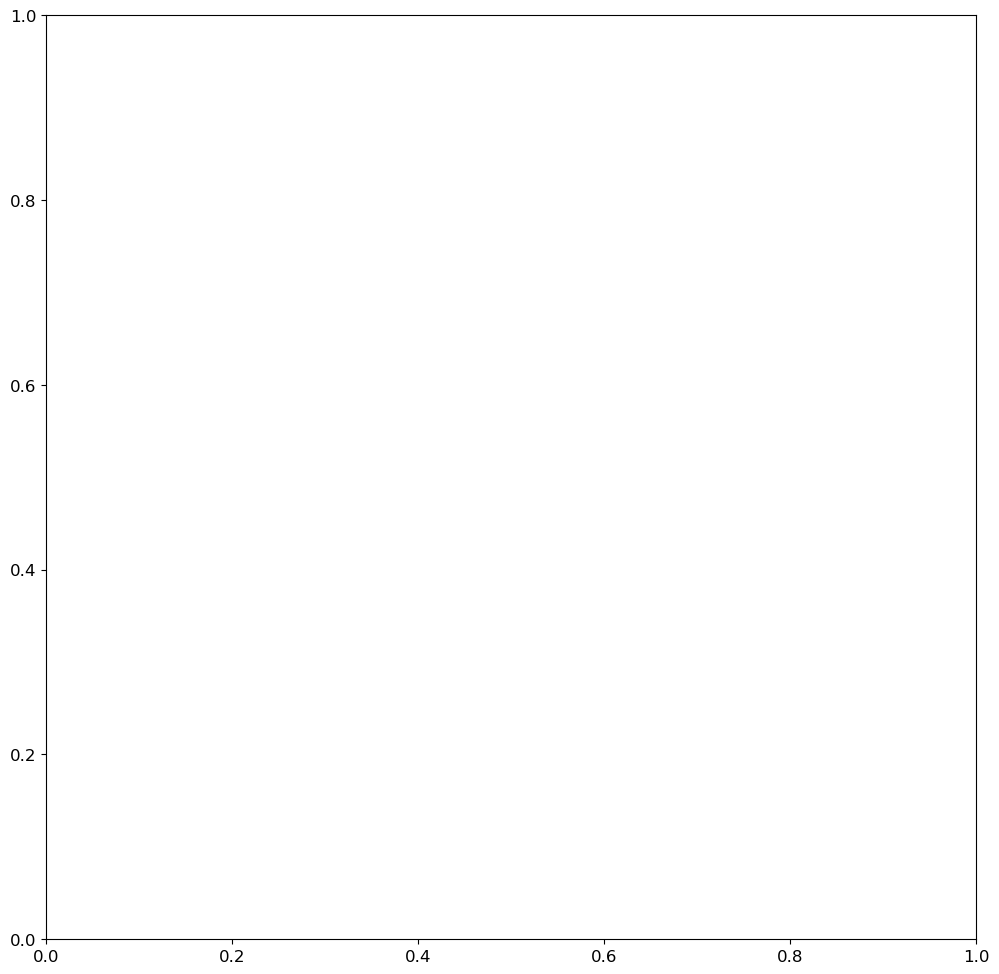

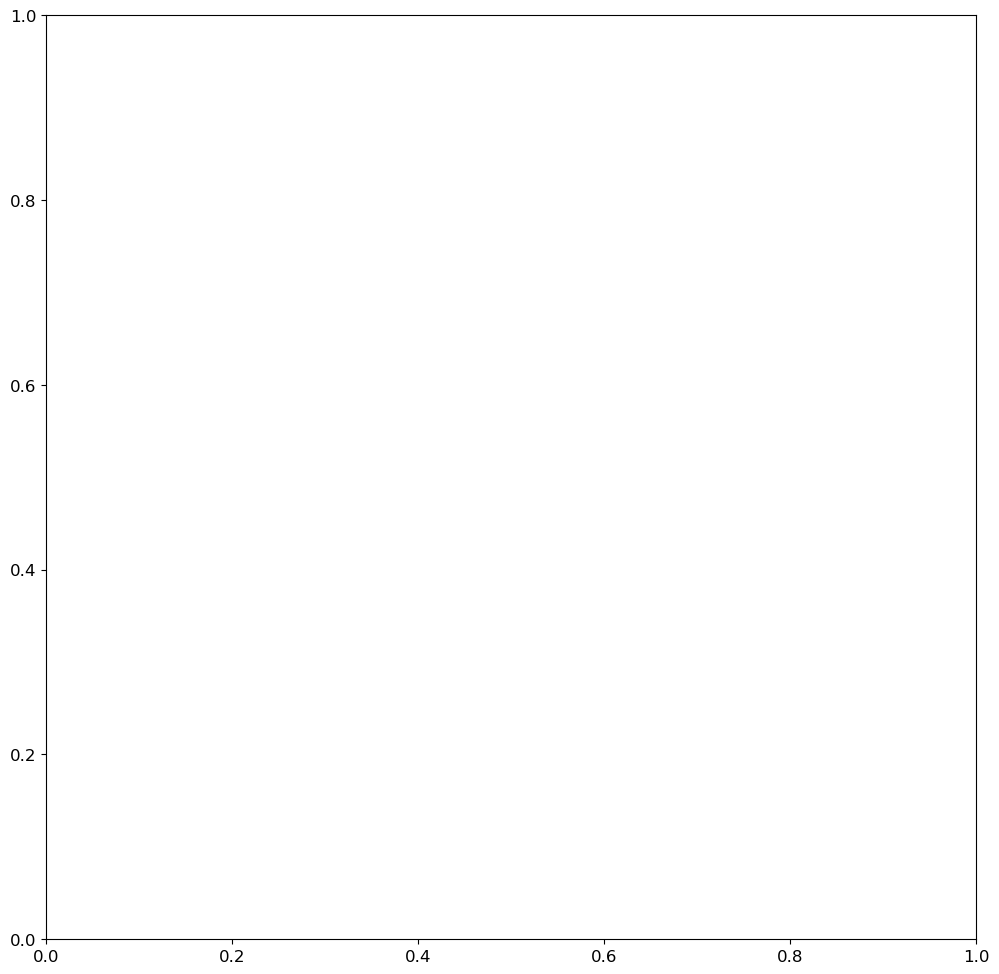

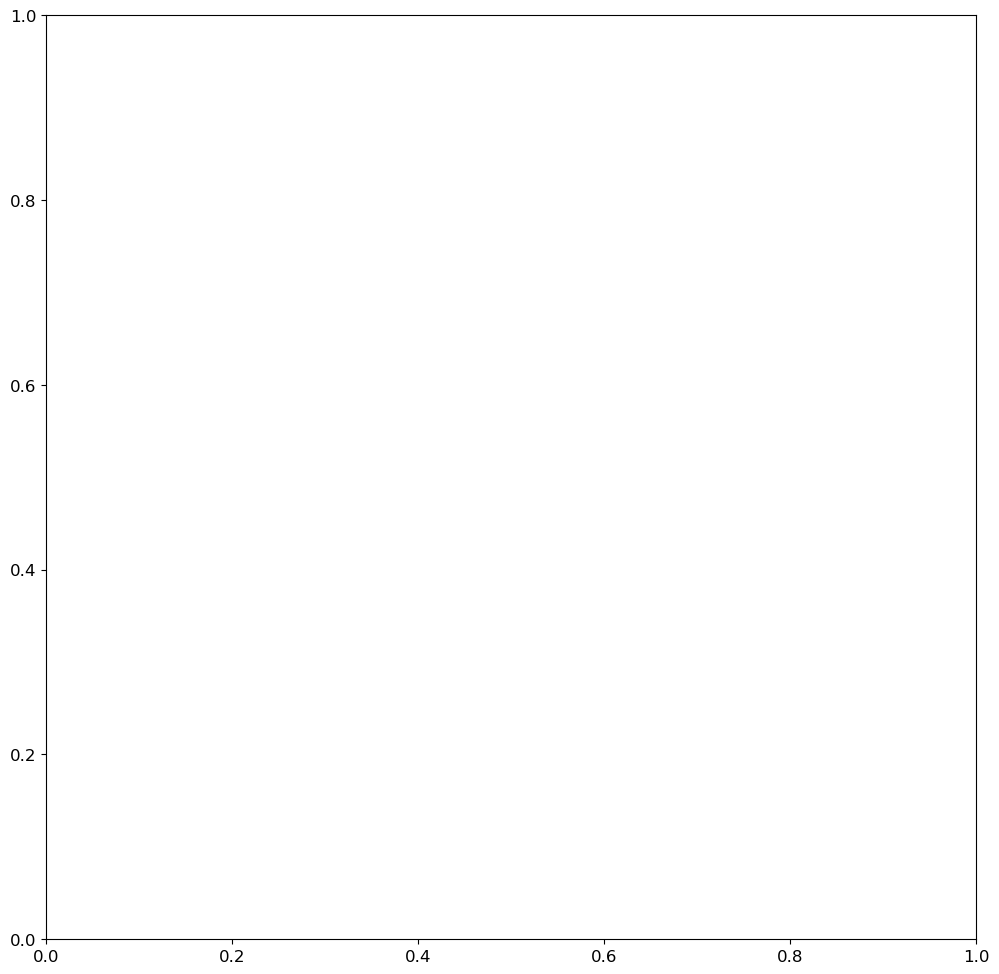

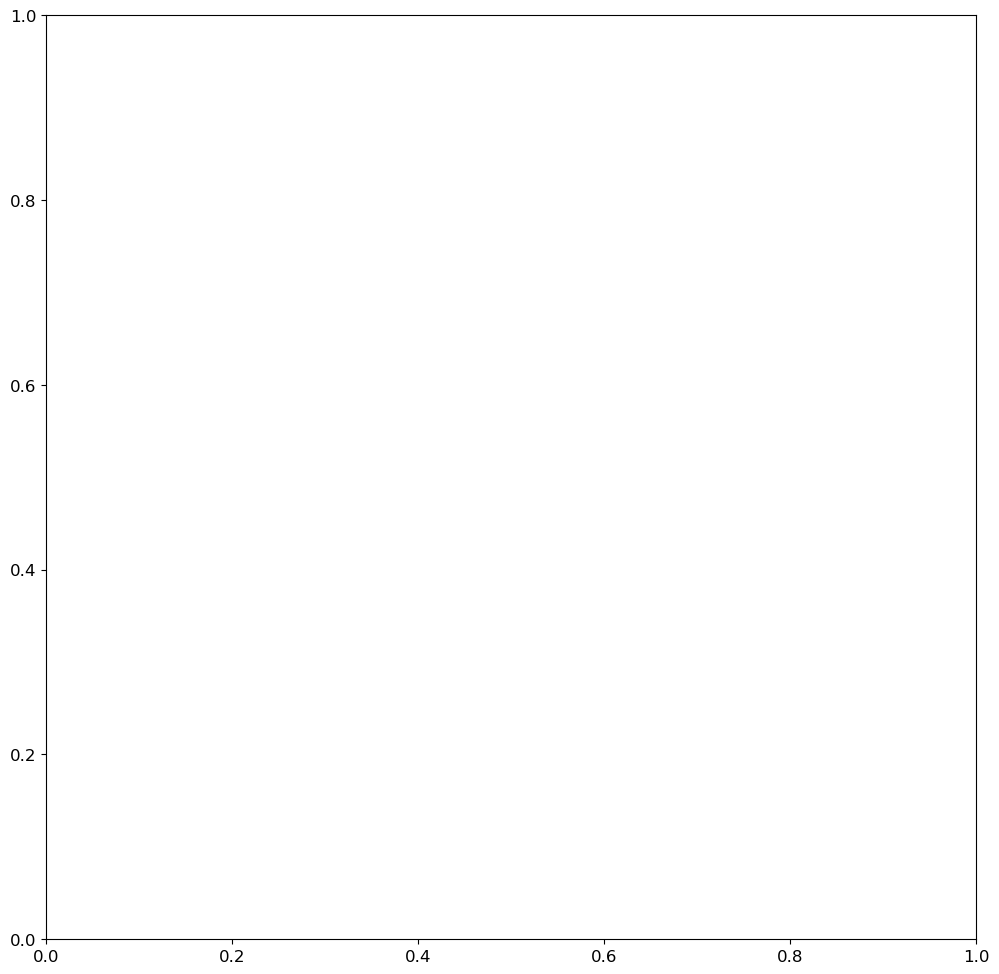

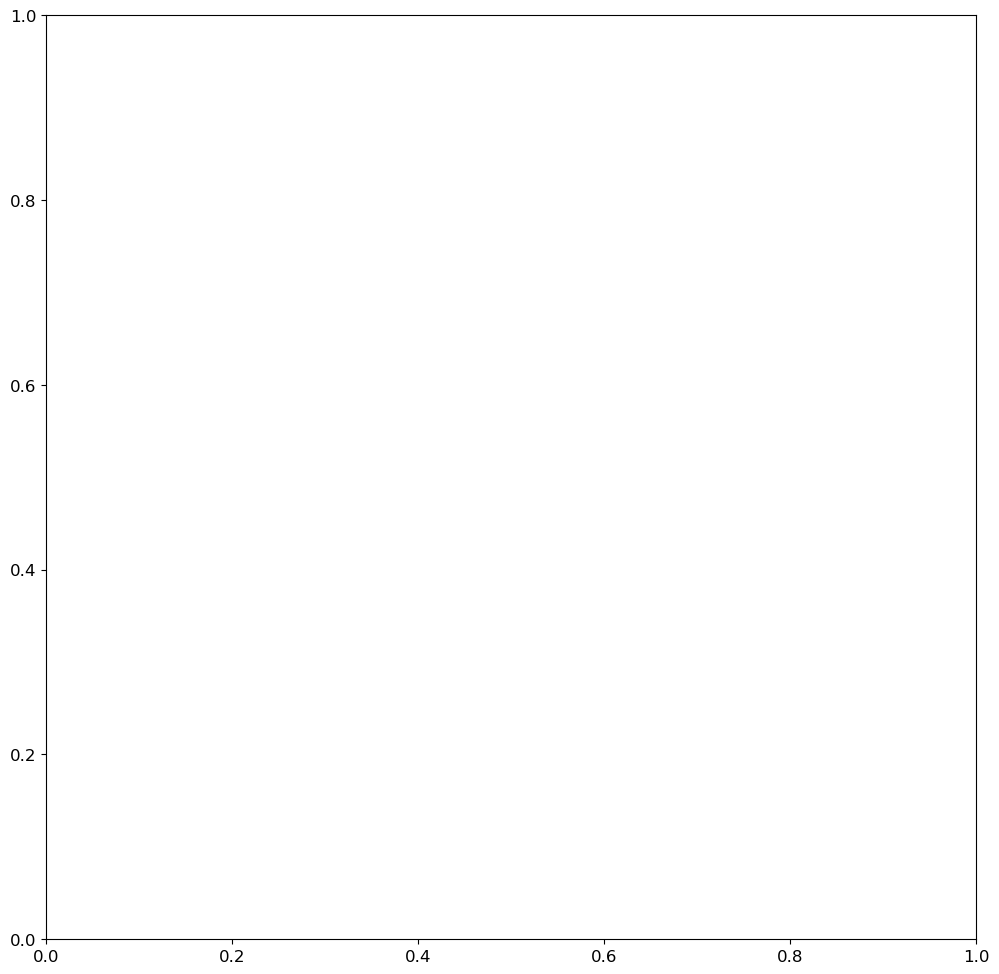

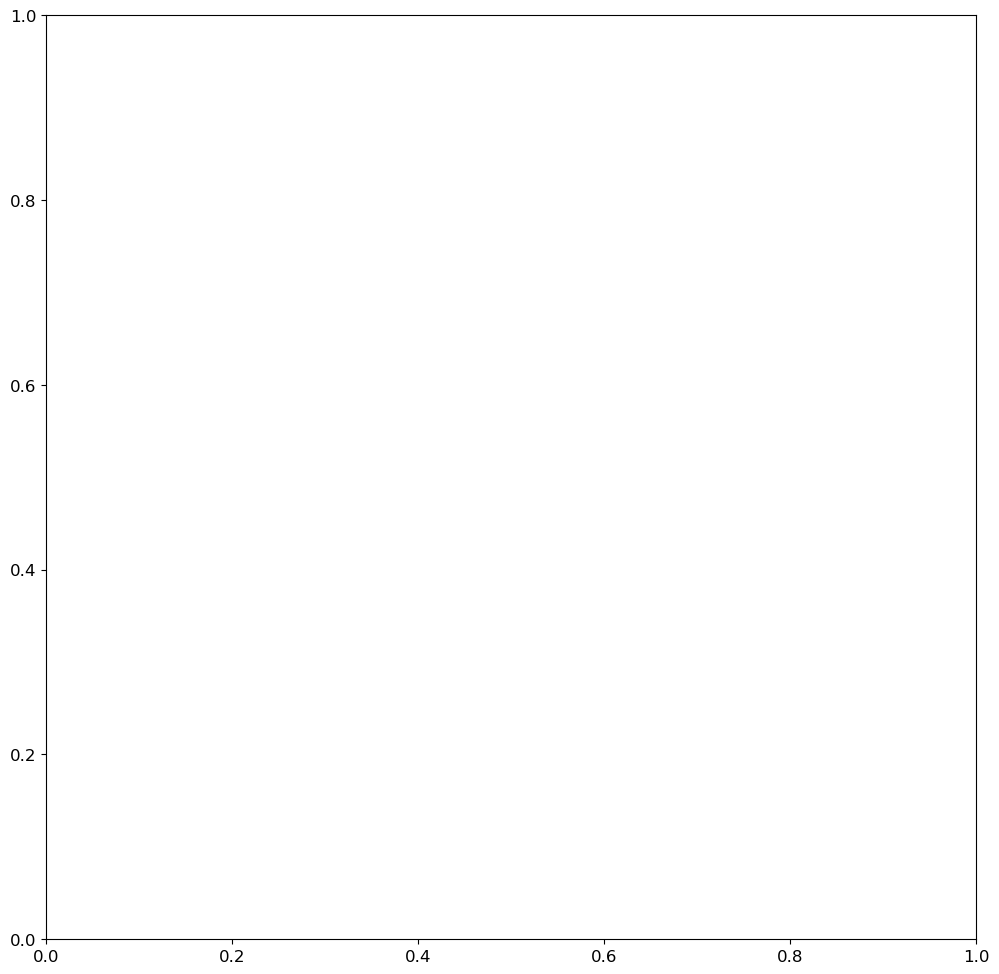

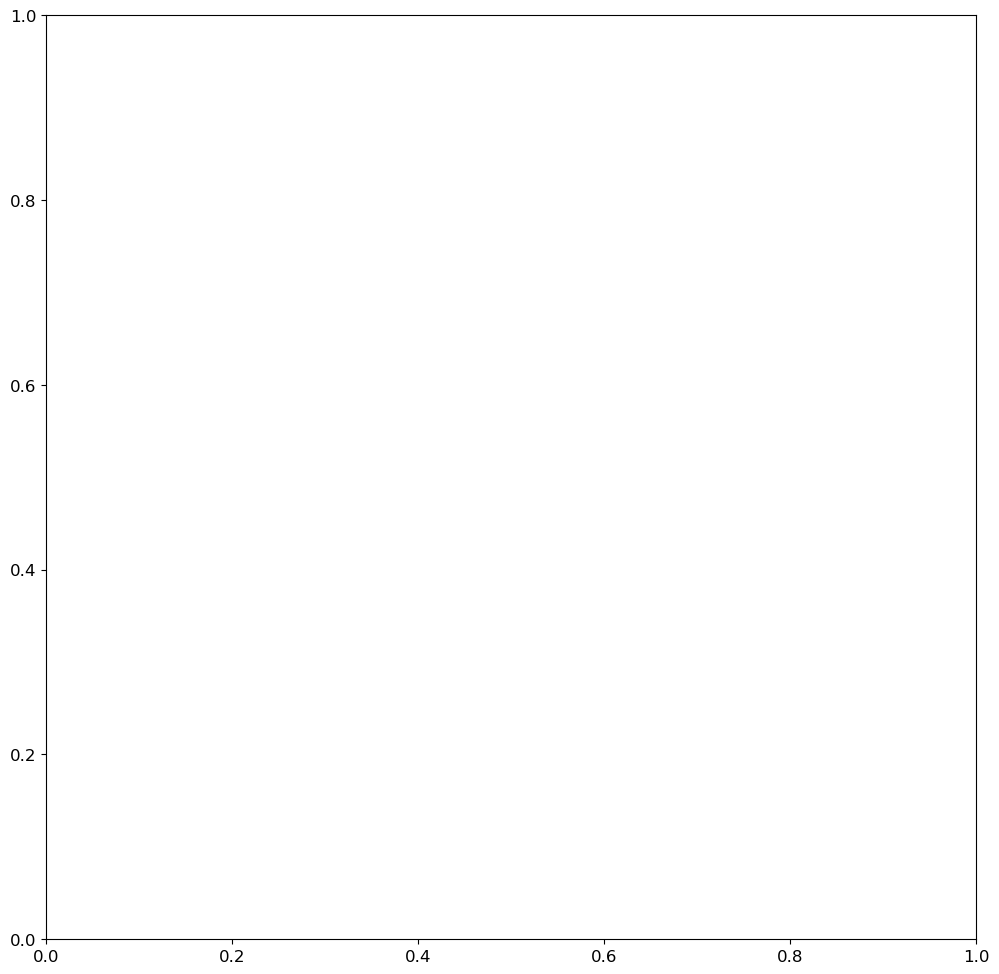

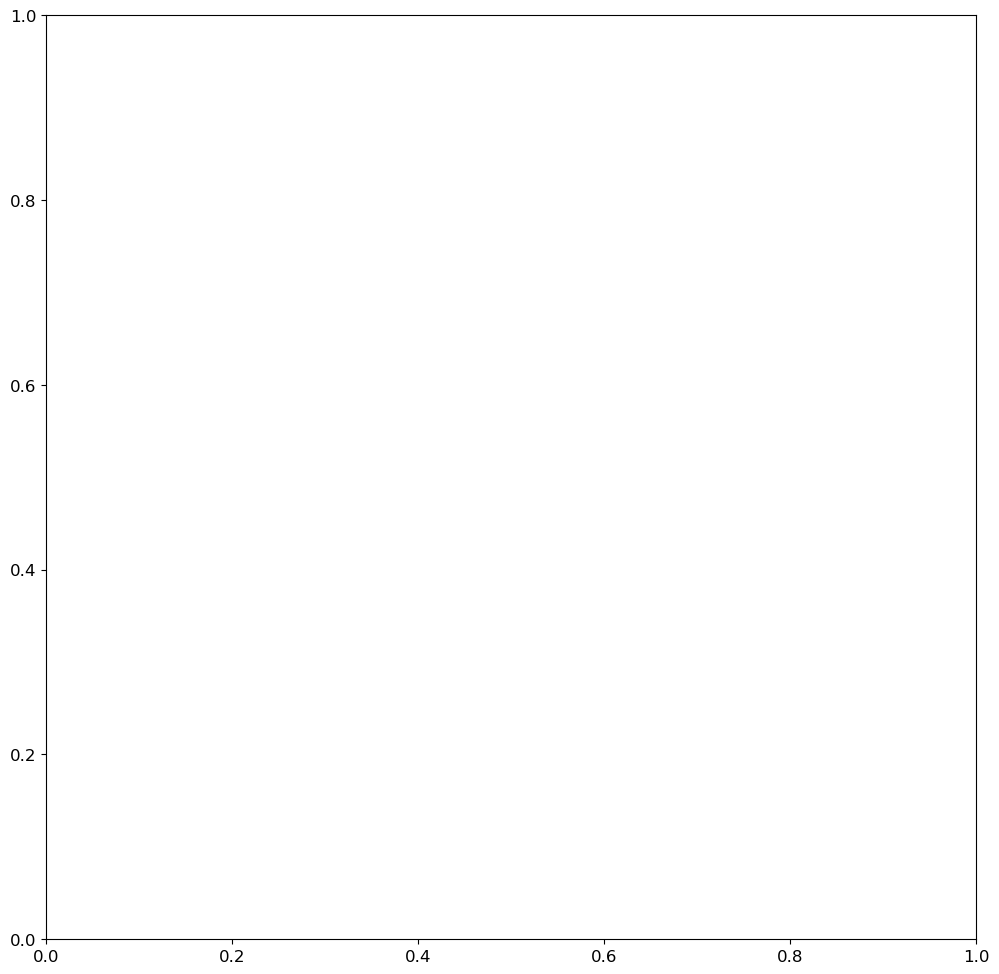

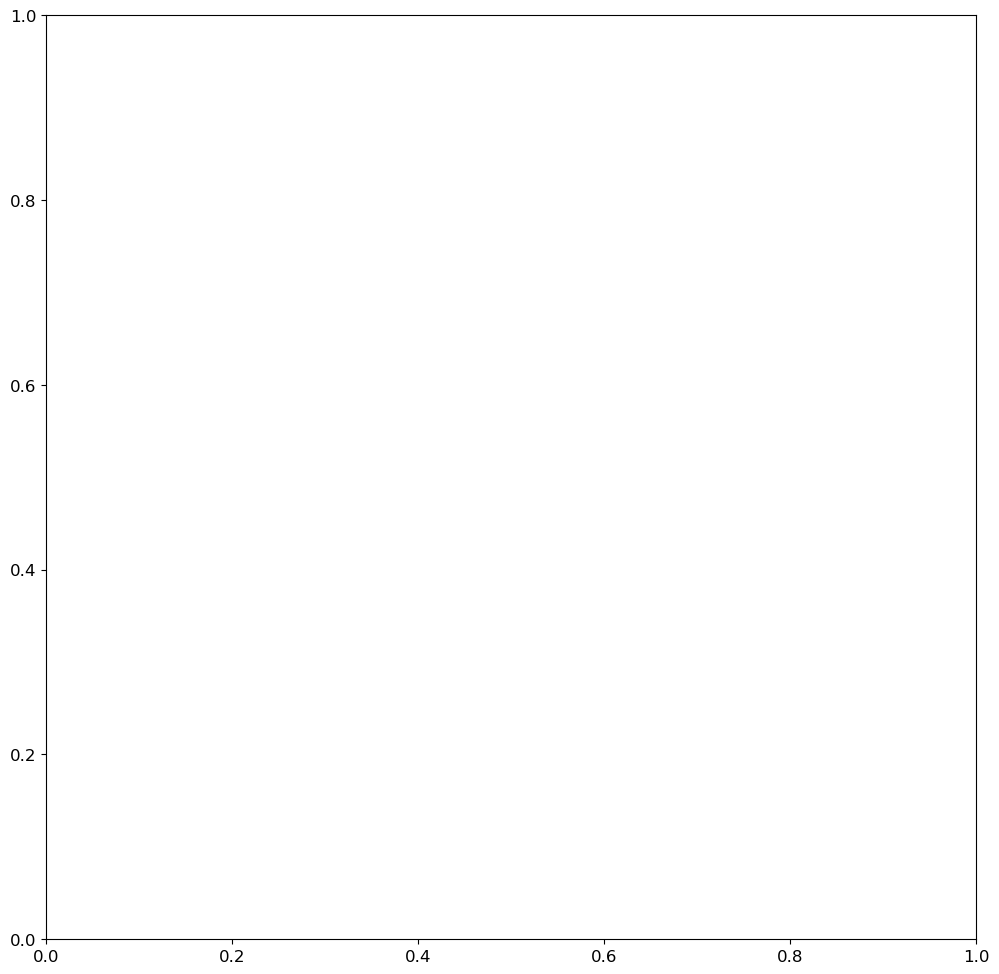

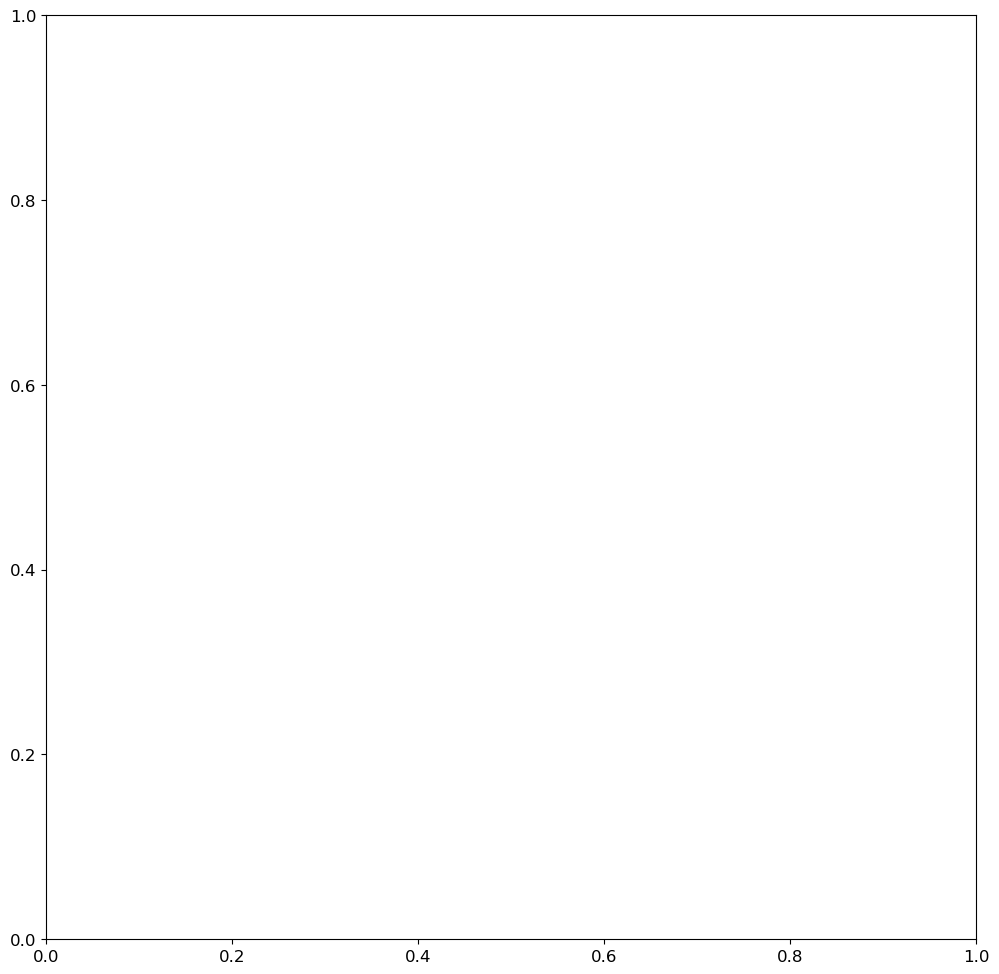

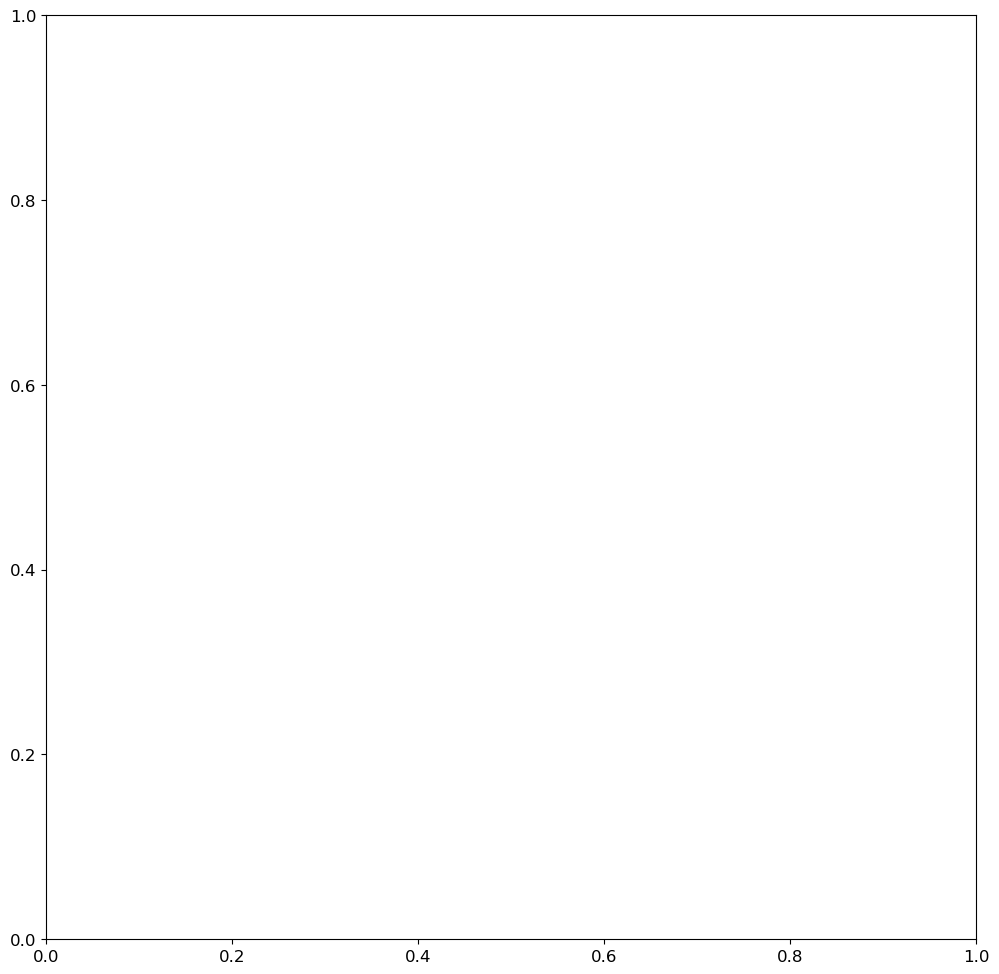

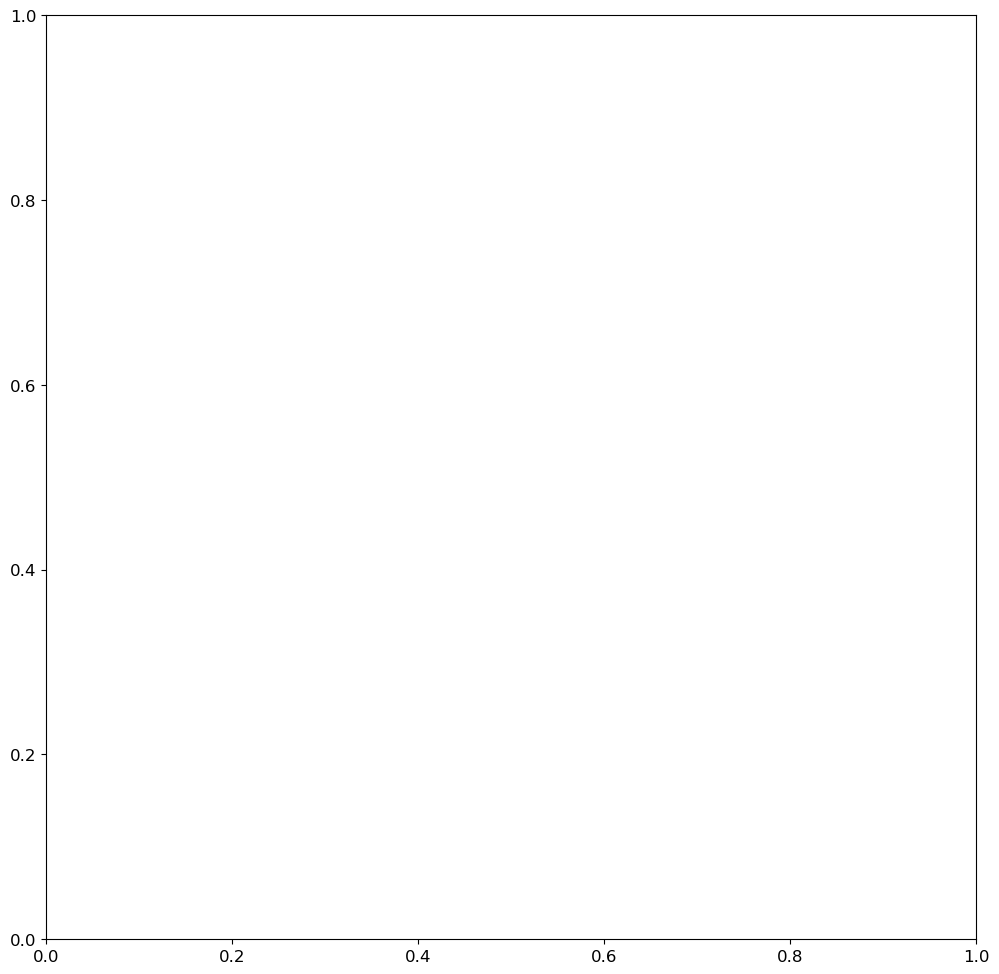

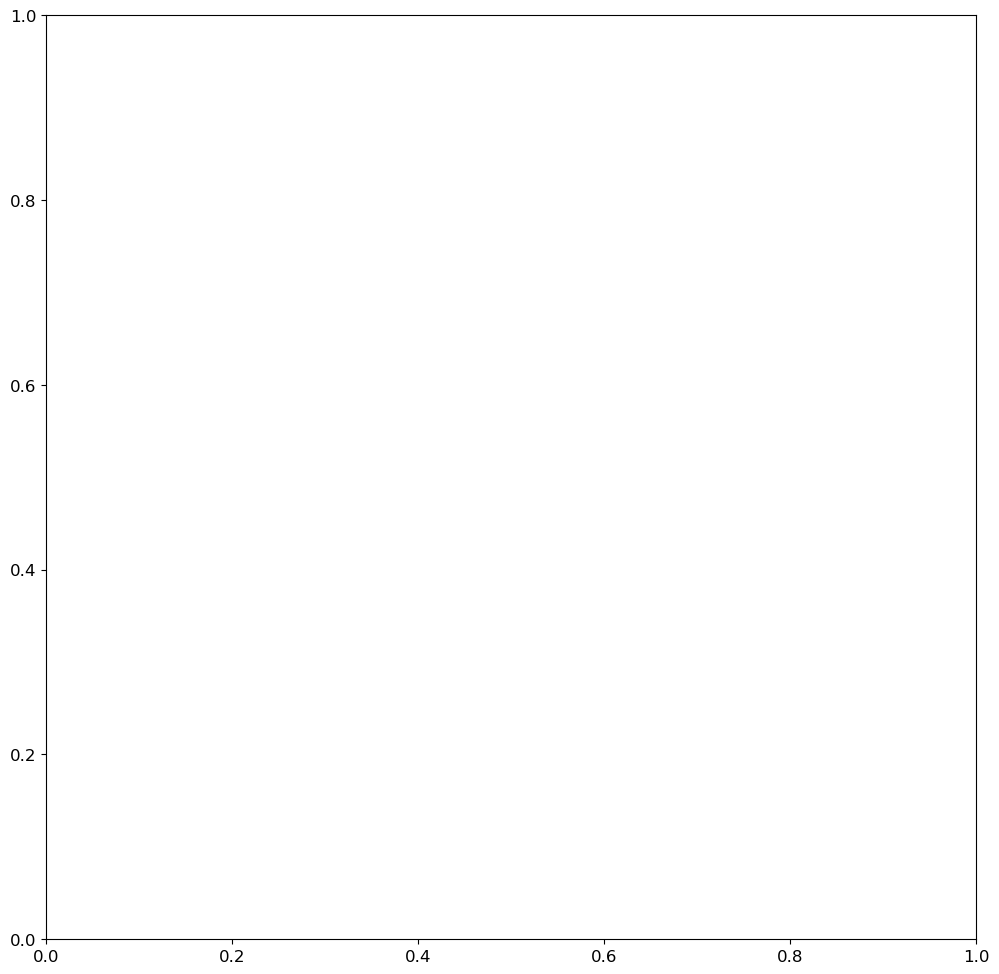

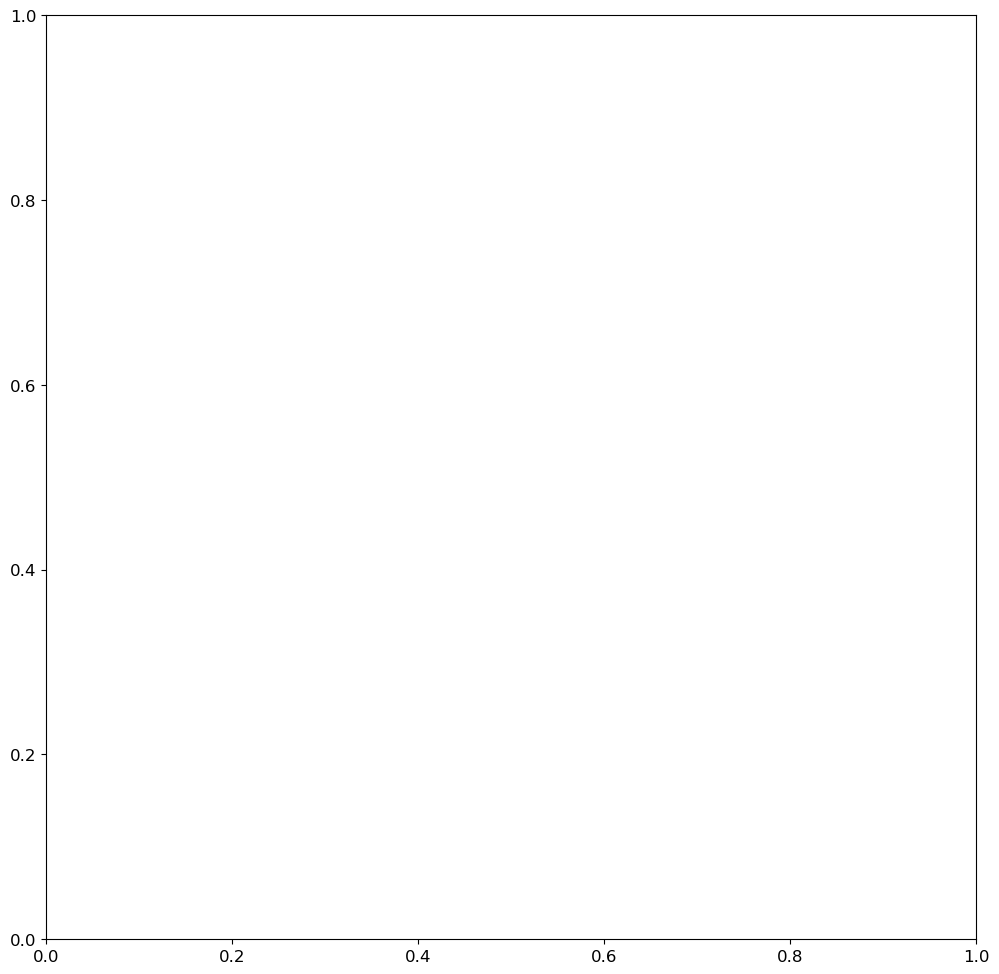

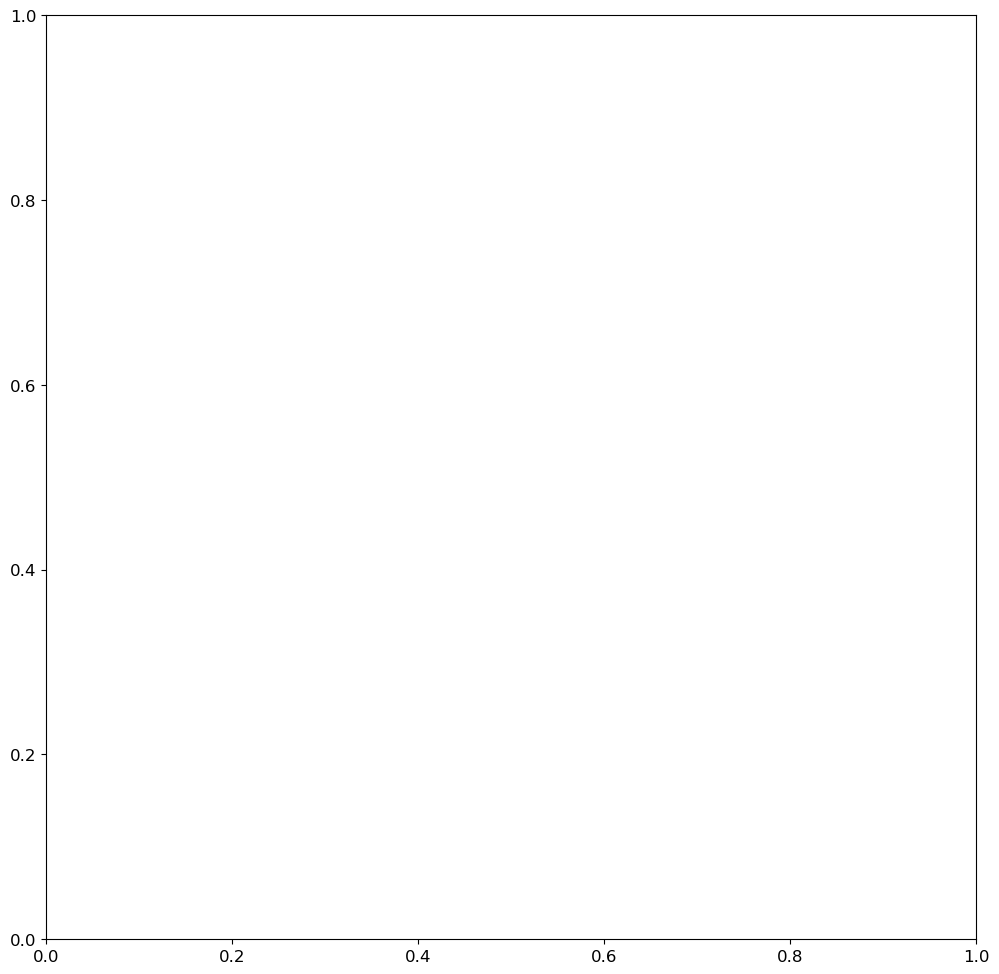

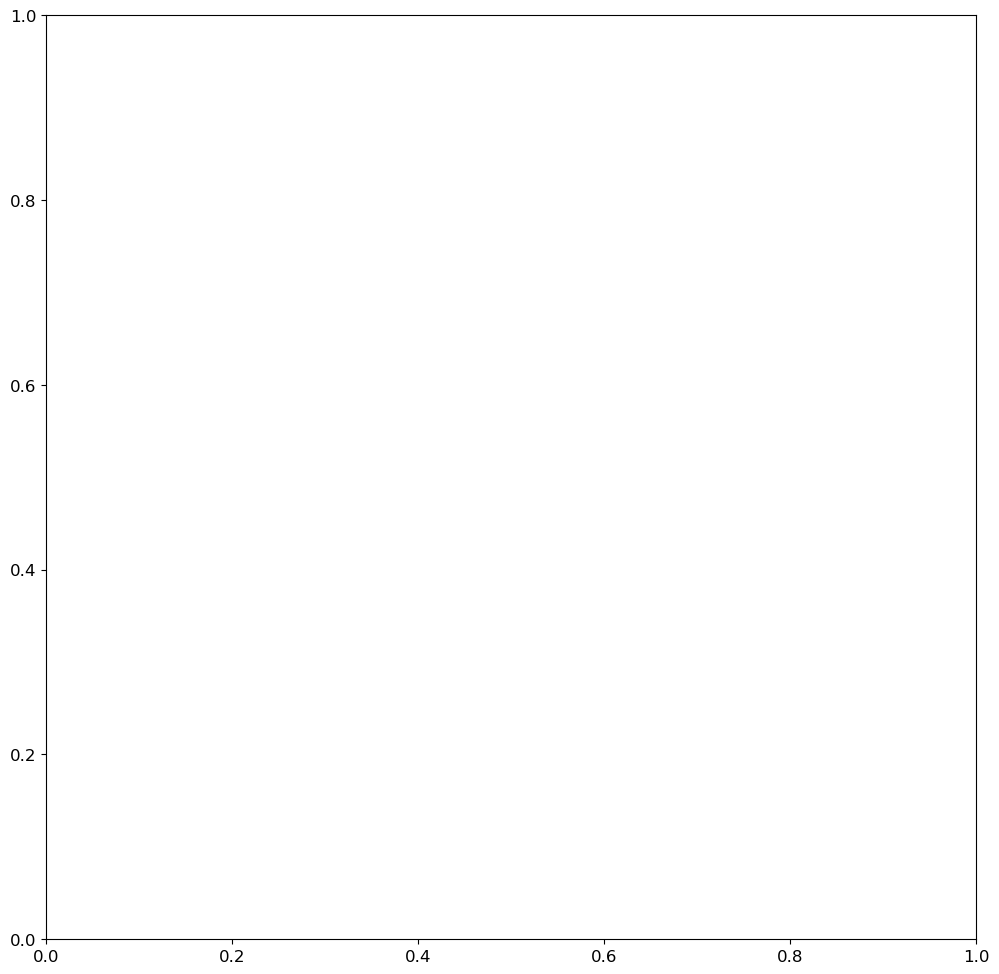

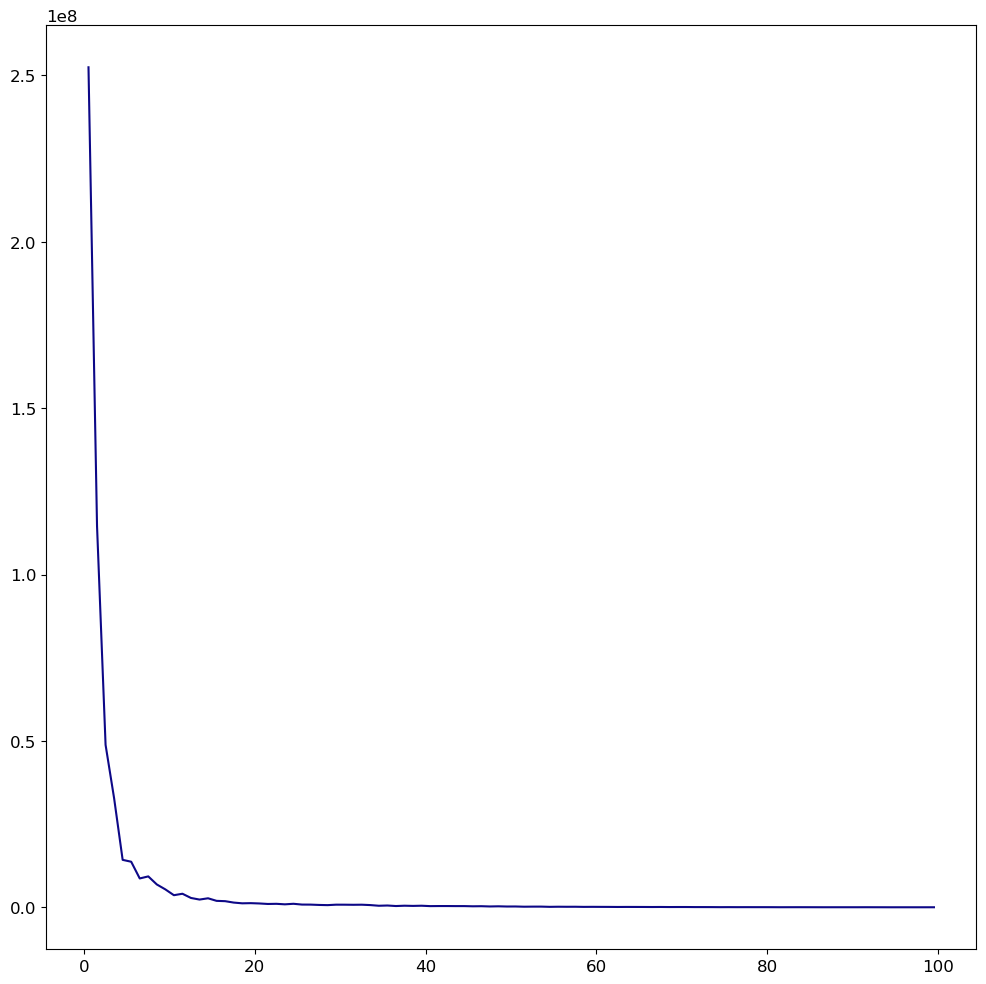

In [ ]:
for redshift in tqdm(zs):

    fig, ax = plt.subplots(1, 1, figsize=[12, 12])

    runf = cosmoSim(CDM_RUNS[0])
    idx = runf.redshift_to_index(redshift)

    # diagnostic only
    if idx < 64:
        continue

    # plot 2cDM runs
    for rn in tcDM_RUNS:
        run = cosmoSim(rn)
        
        # print(idx, rn)
        try:
            rbins, masses = calculate_profile(rn, redshift)
        except KeyError:
            print(f'Error with run {rn} for profile {idx}')
            print('Skipping...')
            continue

        plt.plot(rbins, masses, color=s_map.to_rgba(run.Vkick))

    fig.colorbar(s_map, label='$V_{kick}$ [km s$^{-1}$]', ax=ax)

    # plot CDM run
    for rn in CDM_RUNS:

        rbins, masses = calculate_profile(rn, redshift)

        plt.plot(rbins, masses, color='k', linestyle=(5, (10, 3)))

    # plot formatting
    ax.set_xlabel('$r$ [kpc]')
    ax.set_ylabel(r'$\rho$ [M$_{\odot}$ kpc$^{-3}$]')

    ax.vlines(soft_eff, 10**2, 10**50, colors='k', linestyles='dashed')
    ax.vlines(2.8*soft_eff, 10**2, 10**50, colors='k', linestyles='dashdot')

    ax.set_ylim([10**3, 10**10])

    ax.plot([],[], label=f'z = {redshift:.3f}', alpha=0)

    ax.set_yscale("log")
    ax.set_xscale("log")
    ax.grid(True, which="both", ls="-")
    ax.set_box_aspect(aspect=1)
    ax.legend()
    plt.title('Density Profile 710 HY')

    fname = f'density_710_HY_{idx:03}.png'
    plt.savefig(out_path + fname)

    plt.close(fig)